In [1]:
colab = False
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torchsummary import summary
import matplotlib.pyplot as plt

import os
import math
import time
import sys
import shutil
import copy
import IPython.display as ipd

import numpy as np

if colab:
  !pip install -q livelossplot
  !pip install -q kaldi_io
  !pip install -q kaldiio
  os.environ['KALDI_ROOT'] = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild'
else:
    os.environ['KALDI_ROOT'] = '/opt/kaldi/'
    
import kaldi_io
import kaldiio
#from livelossplot import PlotLosses
import librosa
from tqdm.notebook import tqdm
#from pesq import pesq

In [2]:
from datasets import SequenceDataset
from utils import ScheduledOptim, change_path_scp, EnergyConservingLoss, plot_modelPerformance, l1_mse_loss, splitAudio

In [3]:
train_dataset = SequenceDataset('../data/train/trainTOTAL.scp', '../data/utt2spkTOTAL.scp', min_length = 16000, colab = False)
test_dataset = SequenceDataset('../data/test/testTOTAL.scp', '../data/utt2spkTOTAL.scp', min_length = 16000, colab = False)

Totally 25334 samples with at most 247 samples for one class
Totally 5482 samples with at most 247 samples for one class


In [4]:
train_data = DataLoader(train_dataset, batch_size = 8, shuffle=True)
test_data = DataLoader(test_dataset, batch_size = 8, shuffle=True)

In [5]:
import torchaudio

In [6]:
clean, noisy, _ = next(iter(train_data))

In [7]:
clean[0].size()

torch.Size([1, 16000])

In [8]:
new = torch.stft(noisy[1].squeeze(), n_fft = 256)

In [11]:
new.size()

torch.Size([129, 251, 2])

In [23]:
new.reshape(2, 129, 251)

torch.Size([2, 129, 251])

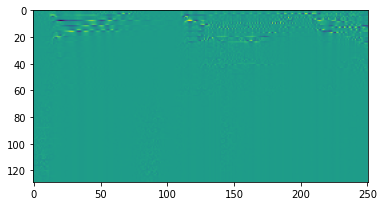

In [32]:
plt.imshow(new[:,:,0])

In [15]:
ipd.Audio(torch.istft(new, n_fft = 256), rate = 16000)

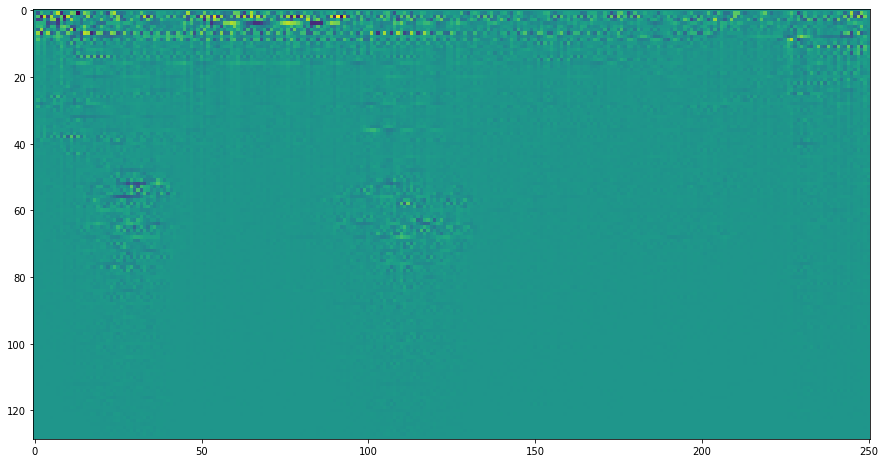

In [35]:
plt.figure(figsize = (15, 8))
plt.imshow(new[:,:,1])

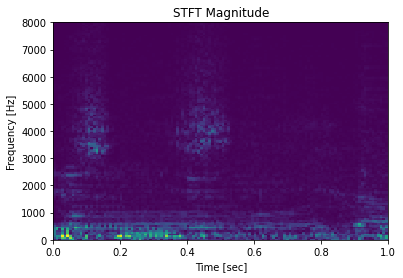

In [75]:
f, t, Zxx = scipy.signal.stft(noisy[1].squeeze(), fs = 16000)
plt.pcolormesh(t, f, np.abs(Zxx))#, vmin=0, vmax=amp, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [77]:
!pip install --upgrade torch

     |████████████████████████████████| 748.8 MB 10 kB/s s eta 0:00:01   |▋                               | 13.0 MB 1.9 MB/s eta 0:06:20     |▊                               | 17.7 MB 1.9 MB/s eta 0:06:18     |██                              | 47.7 MB 45.5 MB/s eta 0:00:16     |███▍                            | 79.1 MB 46.4 MB/s eta 0:00:15     |████▉                           | 112.2 MB 27.9 MB/s eta 0:00:23     |█████                           | 115.6 MB 27.9 MB/s eta 0:00:23     |█████                           | 119.4 MB 27.9 MB/s eta 0:00:23     |██████▎                         | 146.1 MB 42.7 MB/s eta 0:00:15     |███████                         | 161.4 MB 42.7 MB/s eta 0:00:14     |███████                         | 165.1 MB 42.7 MB/s eta 0:00:14     |█████████▏                      | 213.2 MB 16.3 MB/s eta 0:00:33     |█████████▍                      | 219.5 MB 16.3 MB/s eta 0:00:33     |█████████▊                      | 227.6 MB 16.3 MB/s eta 0:00:32     |██████████▏           

In [37]:
ipd.Audio(noisy[1], rate = 16000)

In [43]:
torch.ifft(new, signal_ndim = 1).size()

torch.Size([129, 251, 2])

In [67]:
_,_,new = scipy.signal.stft(noisy[1].squeeze(), fs = 16000)

In [68]:
new.shape

(129, 126)

TypeError: Image data of dtype complex64 cannot be converted to float

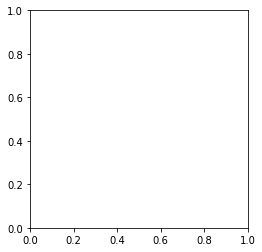

In [58]:
plt.imshow(new)

In [57]:
old = scipy.signal.istft(new, fs = 16000)[1].shape

In [71]:
torch.__version__

'1.4.0'

In [33]:
class ConvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, activation=True, batch_norm=True):
        super(ConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding)
        self.activation = activation
        self.lrelu = torch.nn.LeakyReLU(0.2, True)
        self.batch_norm = batch_norm
        self.bn = torch.nn.BatchNorm2d(output_size)

    def forward(self, x):
        if self.activation:
            out = self.conv(self.lrelu(x))
        else:
            out = self.conv(x)

        if self.batch_norm:
            return self.bn(out)
        else:
            return out


class DeconvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, batch_norm=True, dropout=False):
        super(DeconvBlock, self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size, output_size, kernel_size, stride, padding)
        self.bn = torch.nn.BatchNorm2d(output_size)
        self.drop = torch.nn.Dropout(0.5)
        self.relu = torch.nn.ReLU(True)
        self.batch_norm = batch_norm
        self.dropout = dropout

    def forward(self, x):
        if self.batch_norm:
            out = self.bn(self.deconv(self.relu(x)))
        else:
            out = self.deconv(self.relu(x))

        if self.dropout:
            return self.drop(out)
        else:
            return out


class Generator(torch.nn.Module):
    def __init__(self, input_dim, num_filter, output_dim):
        super(Generator, self).__init__()

        # Encoder
        self.conv1 = ConvBlock(input_dim, num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(num_filter, num_filter * 2)
        self.conv3 = ConvBlock(num_filter * 2, num_filter * 4)
        self.conv4 = ConvBlock(num_filter * 4, num_filter * 8)
        self.conv5 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv6 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv7 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv8 = ConvBlock(num_filter * 8, num_filter * 8, batch_norm=False)
        # Decoder
        self.deconv1 = DeconvBlock(num_filter * 8, num_filter * 8, dropout=True)
        self.deconv2 = DeconvBlock(num_filter * 8 * 2, num_filter * 8, dropout=True)
        self.deconv3 = DeconvBlock(num_filter * 8 * 2, num_filter * 8, dropout=True)
        self.deconv4 = DeconvBlock(num_filter * 8 * 2, num_filter * 8)
        self.deconv5 = DeconvBlock(num_filter * 8 * 2, num_filter * 4)
        self.deconv6 = DeconvBlock(num_filter * 4 * 2, num_filter * 2)
        self.deconv7 = DeconvBlock(num_filter * 2 * 2, num_filter)
        self.deconv8 = DeconvBlock(num_filter * 2, output_dim, batch_norm=False)

    def forward(self, x):
        # Encoder
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)
        enc6 = self.conv6(enc5)
        enc7 = self.conv7(enc6)
        enc8 = self.conv8(enc7)
        # Decoder with skip-connections
        dec1 = self.deconv1(enc8)
        dec1 = torch.cat([dec1, enc7], 1)
        dec2 = self.deconv2(dec1)
        dec2 = torch.cat([dec2, enc6], 1)
        dec3 = self.deconv3(dec2)
        dec3 = torch.cat([dec3, enc5], 1)
        dec4 = self.deconv4(dec3)
        dec4 = torch.cat([dec4, enc4], 1)
        dec5 = self.deconv5(dec4)
        dec5 = torch.cat([dec5, enc3], 1)
        dec6 = self.deconv6(dec5)
        dec6 = torch.cat([dec6, enc2], 1)
        dec7 = self.deconv7(dec6)
        dec7 = torch.cat([dec7, enc1], 1)
        dec8 = self.deconv8(dec7)
        out = torch.nn.Tanh()(dec8)
        return out

In [47]:
net = Generator(2, 64, 2)

In [43]:
new[:,:,0].reshape(1, 1, 129, 251)

tensor([[[[-1.1777,  0.3539,  0.1331,  ..., -2.0510, -2.0177, -2.1591],
          [-1.1951,  0.5687,  0.2275,  ..., -3.3743, -0.9567,  1.2288],
          [-1.1196, -0.2360,  2.1925,  ..., -3.5657,  1.6336, -4.3817],
          ...,
          [-2.0146,  1.4944, -1.6920,  ...,  0.0689,  0.0618, -0.0276],
          [-0.4673, -0.1294, -0.6587,  ...,  0.0757,  0.0615, -0.0325],
          [ 1.2330,  1.5390,  0.6114,  ...,  0.0576,  0.0379, -0.0485]]]])

In [48]:
net(new.reshape(1, 2, 129, 251))

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])